   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2021, MBARI</div>
    
  * Distributed under the terms of the GPL License
  * Maintainer: dcline@mbari.org
  * Authors: Danelle Cline dcline@mbari.org, John Ryan ryjo@mbari.org

## Basic Exploration of the 16 kHz Pacific Ocean Audio Data in the AWS Open Data Registry

---
An extensive (5+ years and growing) archive of sound recordings from a deep-sea location [along the eastern margin of the North Pacific Ocean](https://www.mbari.org/at-sea/cabled-observatory/) has been made available through AWS Open data.  Temporal coverage of the recording archive has been 95% since project inception in July 2015.  The original recordings have a sample rate of 256 kHz.  For many research applications it is convenient to work with data having a lower sample rate.  This notebook illustrates basic methods to access and process a calibrated spectrogram from the decimated 16 kHz audio archive.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**


## Data Overview
The decimated audio data are in [WAV](https://en.wikipedia.org/wiki/WAV) format in an s3 bucket named <b>pacific-sound-16khz</b>.  They are further organized by year and month.  Buckets are stored as objects, so the data isn't physically stored in folders or directories as you may be famaliar with, but you can think of it conceptually as follows:

```
pacific-sound-16khz
      |
      ----2020
        |
        |----01
        ...
        |----12
```


## Install dependencies
First, let's install dependencies and include all packages used in this tutorial. This only needs to be done once for the duration of this notebook.

In [1]:
!pip install -q boto3
!pip install -q soundfile
!pip install -q scipy
!pip install -q numpy
!pip install -q matplotlib
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import os
import scipy
from scipy import signal
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## List the contents of a monthly directory

In [2]:
s3_client = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [3]:
year = "2018"
month = "01"
bucket = 'pacific-sound-16khz'

for obj in s3_client.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
    print(obj['Key'])

2018/01/MARS-20180101T000000Z-16kHz.wav
2018/01/MARS-20180102T000000Z-16kHz.wav
2018/01/MARS-20180103T000000Z-16kHz.wav
2018/01/MARS-20180104T000000Z-16kHz.wav
2018/01/MARS-20180105T000000Z-16kHz.wav
2018/01/MARS-20180106T000000Z-16kHz.wav
2018/01/MARS-20180107T000000Z-16kHz.wav
2018/01/MARS-20180108T000000Z-16kHz.wav
2018/01/MARS-20180109T000000Z-16kHz.wav
2018/01/MARS-20180110T000000Z-16kHz.wav
2018/01/MARS-20180111T000000Z-16kHz.wav
2018/01/MARS-20180112T000000Z-16kHz.wav
2018/01/MARS-20180113T000000Z-16kHz.wav
2018/01/MARS-20180114T000000Z-16kHz.wav
2018/01/MARS-20180115T000000Z-16kHz.wav
2018/01/MARS-20180116T000000Z-16kHz.wav
2018/01/MARS-20180117T000000Z-16kHz.wav
2018/01/MARS-20180118T000000Z-16kHz.wav
2018/01/MARS-20180119T000000Z-16kHz.wav
2018/01/MARS-20180123T000000Z-16kHz.wav
2018/01/MARS-20180124T000000Z-16kHz.wav
2018/01/MARS-20180125T000000Z-16kHz.wav
2018/01/MARS-20180126T000000Z-16kHz.wav
2018/01/MARS-20180127T000000Z-16kHz.wav
2018/01/MARS-20180128T000000Z-16kHz.wav


## Retrieve metadata for a file

In [4]:
year = "2018"
month = "01"
filename = 'MARS-20180101T000000Z-16kHz.wav'
bucket = 'pacific-sound-16khz'
key = f'{year}/{month}/{filename}'

url = f'https://{bucket}.s3.amazonaws.com/{key}'

sf.info(io.BytesIO(urlopen(url).read(20_000)), verbose=True) 

samplerate: 16000 Hz
channels: 1
duration: 6556 samples
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 6556
extra_info: """
    Length : 20000
    RIFF : 4147200324 (should be 19992)
    WAVE
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 16000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 48000
    LIST : 280
      INFO
        INAM : MBARI ocean audio data, start 20180101T000000 UTC
        ICMT : If you use these data, please cite https://doi.org/10.1109/OCEANS.2016.7761363. Recording metadata can be found at https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json.
    data : 4147200000 (should be 19668)
    End
    """

## Calibrated Spectrum Levels
The file metadata retrieved above includes a link to a json file containing complete deployment metadata.  For convenience, those links (one for each hydrophone deployment) are: 
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

Frequency-dependent hydrophone sensitivity data are included in these json files.  Considering the 16 kHz data, hydrophone sensitivity at only the two lowest frequencies are relevant.  For the example file identified above, which is from the second hydrophone deployment, these sensitivities at 250 Hz and 10 kHz are -177.90 and -176.80 dB V re $\mu$Pa, respectively.  For simplicity in this example, we can apply the average sensitivity, -177.35 dB V re $\mu$Pa.


### Save the daily file

In [5]:
# The 16 kHz daily file may be too large to fit into memory for some instances, so let's download it first
# then seek into the file to read a chunk later
print(f'Copying s3://{bucket}/{key}')

# A boto3 session needs your AWS access credentials in a safe spot that the boto3 session will understand
# The recommended way to do that is outside of SageMaker is by installing the aws command line tools and running `aws configure`
# If you are running this in SageMaker configuring is not required to read this public S3 bucket.

if not os.path.exists(filename):
    session = boto3.Session()
    s3_session = session.resource('s3')
    s3_session.Bucket(bucket).download_file(key, filename)

# Alternatively, it can be downloaded directly in SageMaker with
# !aws s3 cp s3://{bucket}/{key} .

Copying s3://pacific-sound-16khz/2018/01/MARS-20180101T000000Z-16kHz.wav


### Read hours 9-12 of the day

In [6]:
sample_rate = int(16e3)
start_frame = int(sample_rate*9*3600)
duration_frames =  int(sample_rate*3*3600)

pacsound_file = sf.SoundFile(filename)
pacsound_file.seek(start_frame)
x = pacsound_file.read(duration_frames, dtype='float32')    

In [7]:
v = x*3   # convert scaled voltage to volts
v.shape, v.size, sample_rate
a = np.arange(v.size)+1
# define segment processing
nsec = (v.size)/sample_rate # number of seconds in vector
spa = 60  # seconds per average
nseg = int(nsec/spa)
print(nseg,'segments of length',spa,'seconds','in',nsec,'seconds of audio')

360 segments of length 60 seconds in 21600.0 seconds of audio


In [8]:
# initialize empty spectrogram matrix
nfreq = int(sample_rate/2+1)
nfreq,nseg
sg = np.empty((nfreq, nseg), float)
sg.shape

(8001, 360)

In [9]:
# get window for welch
w = scipy.signal.get_window('hann',sample_rate)

# process spectrogram
for x in range(0,nseg):
  cstart = x*spa*sample_rate
  cend = (x+1)*spa*sample_rate
  f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd) + 177.35
  sg[:,x] = psd

### Plot the spectrogram of the 6-hour window
Note: The sharp drop in signal approaching 8 kHz reflects the attributes of the decimation filter applied to produce the 16 kHz data from the original 256 kHz data.

Text(0.5, 1.0, 'Calibrated spectrum levels')

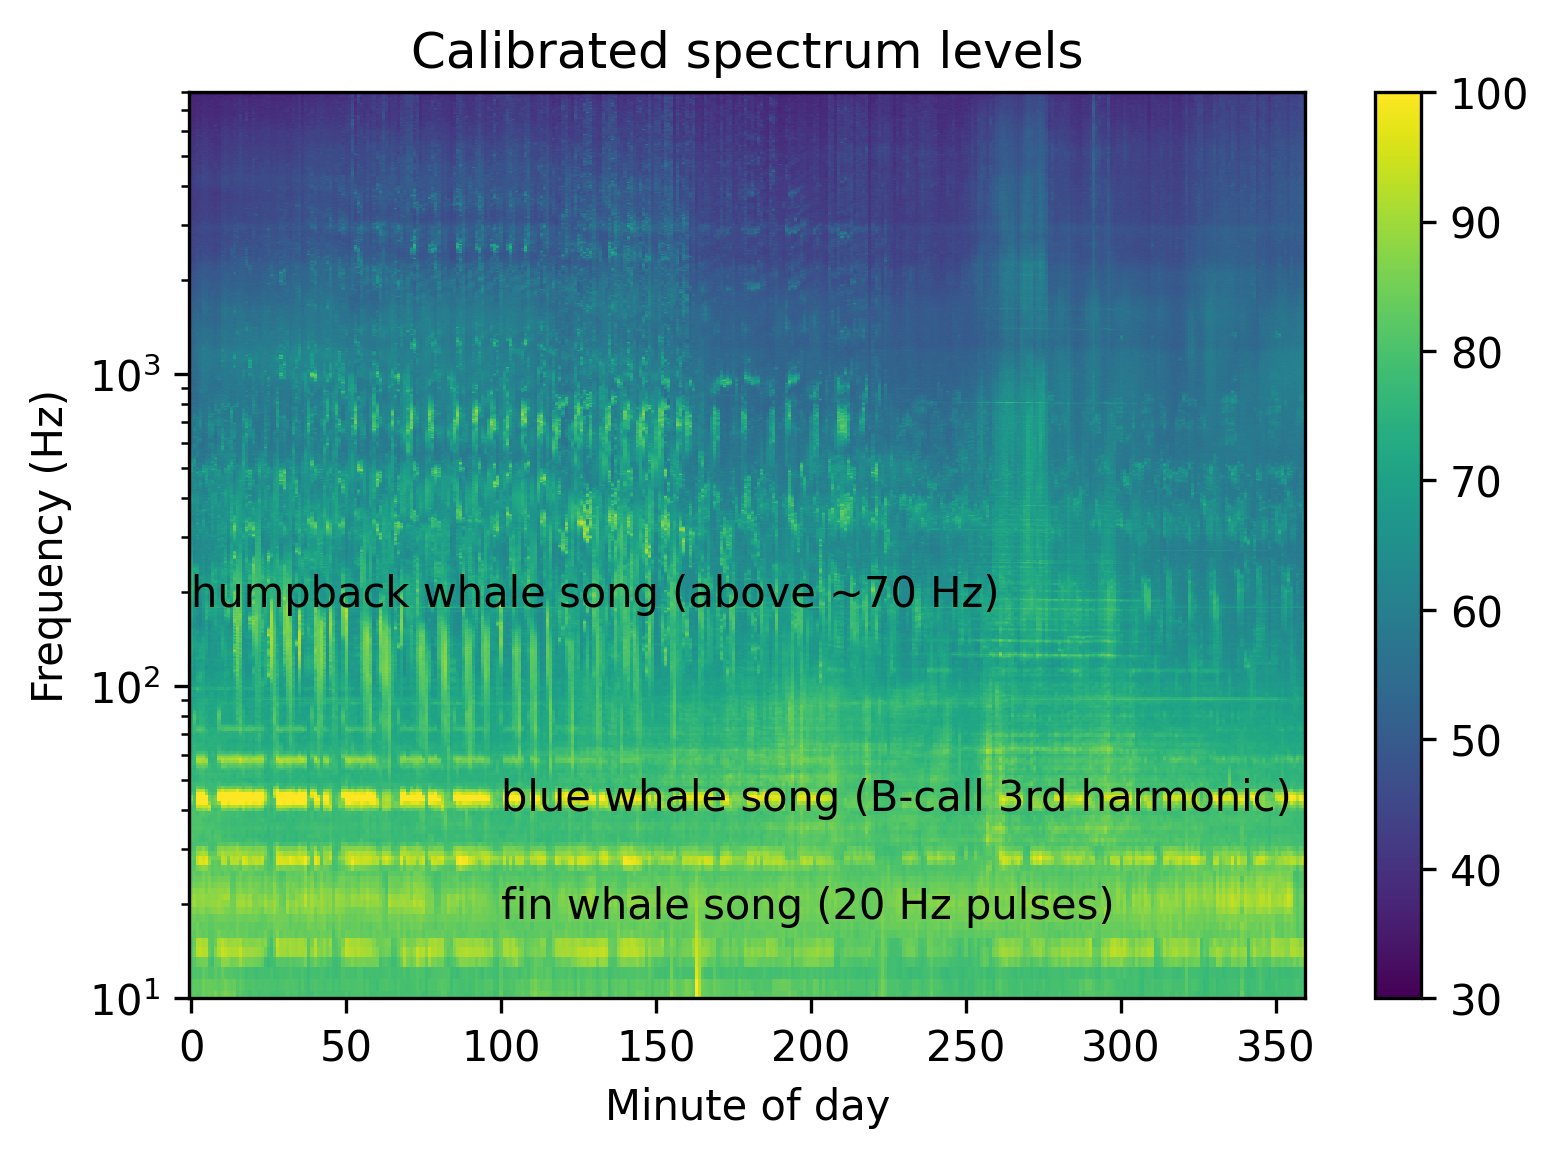

In [10]:
plt.figure(dpi=300)
im = plt.imshow(sg,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,8000)
plt.colorbar(im)
plt.annotate("humpback whale song (above ~70 Hz)",(0,180))
plt.annotate("blue whale song (B-call 3rd harmonic)",(100,40))
plt.annotate("fin whale song (20 Hz pulses)",(100,18))
plt.xlabel('Minute of day')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')

### Zoom-in using a 1-second resolution to see a more detailed of whale song
The temporal resolution of the full-day spectrogram above is too coarse to see the structure of individual whale songs.  So, let's produce and view a calibrated spectrogram with more detail.

In [11]:
# examine the 9th hour of the day at 1 second resolution
spa = 1  # seconds per average
nseg = 3600
sg2 = np.empty((nfreq, nseg), float)
start_sample = int(3600*sample_rate+1)
sg2.shape

(8001, 3600)

In [12]:
# process spectrogram
for x in range(0,nseg):
  cstart = start_sample + x*spa*sample_rate
  cend = cstart+spa*sample_rate
  f,psd = scipy.signal.welch(v[cstart:cend],fs=sample_rate,window=w,nfft=sample_rate)
  psd = 10*np.log10(psd) + 177.35
  sg2[:,x] = psd

/var/folders/p8/dld1k4l14tg5fpljnb32tl9h0000k6/T/ipykernel_1349/3082329902.py:6: RuntimeWarning: divide by zero encountered in log10
  psd = 10*np.log10(psd) + 177.35


Text(0.5, 1.0, 'Calibrated spectrum levels')

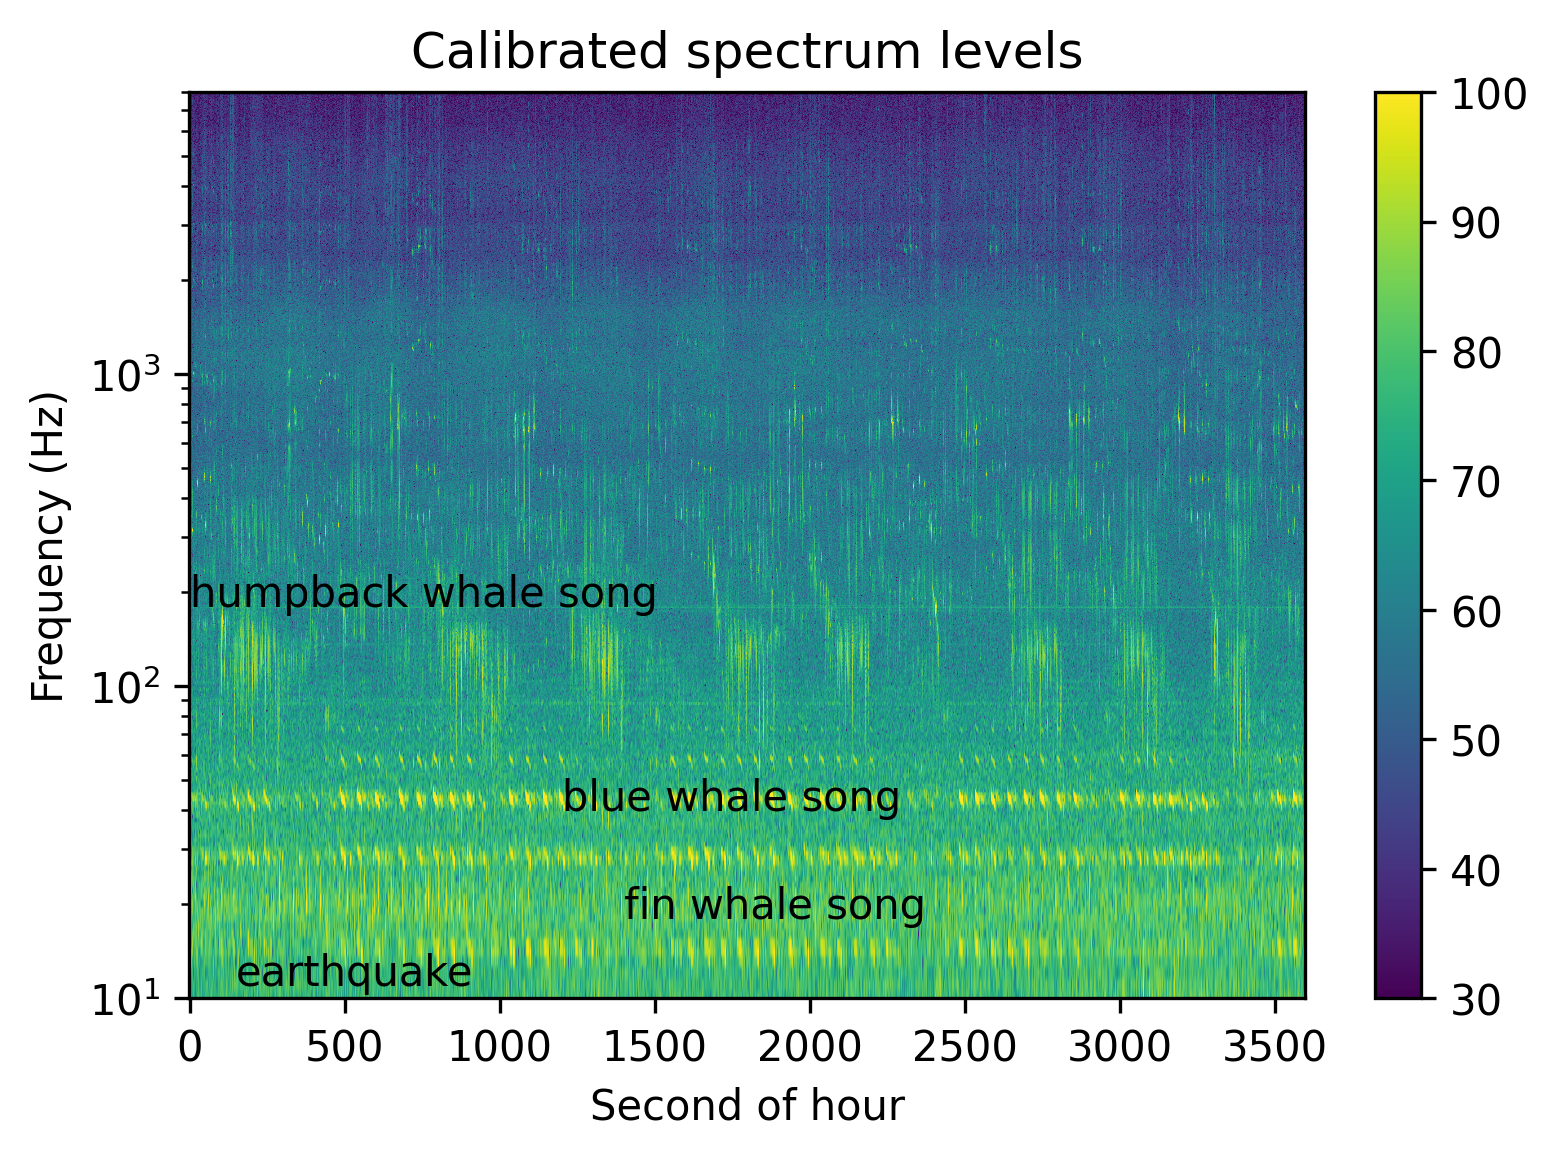

In [13]:
# plot it
plt.figure(dpi=300)
im = plt.imshow(sg2,aspect='auto',origin='lower',vmin=30,vmax=100)
plt.yscale('log')
plt.ylim(10,8000)
plt.colorbar(im)
plt.annotate("humpback whale song",(0,180))
plt.annotate("blue whale song",(1200,40))
plt.annotate("fin whale song",(1400,18))
plt.annotate("earthquake",(150,11))
plt.xlabel('Second of hour')
plt.ylabel('Frequency (Hz)')
plt.title('Calibrated spectrum levels')